<font size="+3">Time-series Generative Adversarial Network (TimeGAN)</font>

# Imports & Settings

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Instal packages / Import Libraries
!pip install tsaug
!pip install fredapi
!pip install sktime

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input, Dropout, BatchNormalization, LeakyReLU, Reshape, Conv1D, Flatten, Conv1DTranspose
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from sktime.utils.plotting import plot_series
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [4]:
import os

In [5]:
#set gpu usage
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [6]:
sns.set_style('white')

# Experiment Path

In [7]:
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()
print(f"Current working directory: {os.getcwd()}")

Current working directory: C:\Users\Kostas\Downloads


In [8]:
experiment = 1

In [9]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [12]:
hdf_store = results_path / 'TimeSeriesGAN.h5'

# Prepare Data

In [13]:
fred = Fred(api_key='18ecafa4ff3f8087c46dd862605532f1')
data = fred.get_series('SP500')

In [14]:
df = pd.DataFrame({
    "WTI": fred.get_series("DCOILWTICO", observation_start="1987-05-20", observation_end="2020-12-31"),
    "BRENT": fred.get_series("DCOILBRENTEU", observation_start="1987-05-20", observation_end="2020-12-31")
})
df.head()

,WTI,BRENT
1987-05-20,19.75,18.63
1987-05-21,19.95,18.45
1987-05-22,19.68,18.55
1987-05-25,NaN,18.60
1987-05-26,19.35,18.63


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8772 entries, 1987-05-20 to 2020-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WTI     8475 non-null   float64
 1   BRENT   8536 non-null   float64
dtypes: float64(2)
memory usage: 205.6 KB


In [16]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8402 entries, 1987-05-20 to 2020-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WTI     8402 non-null   float64
 1   BRENT   8402 non-null   float64
dtypes: float64(2)
memory usage: 196.9 KB


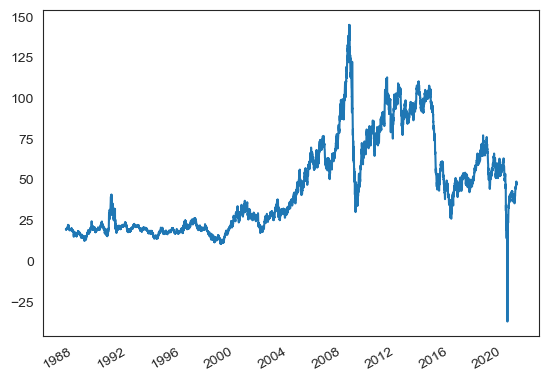

In [17]:
df['WTI'].plot();

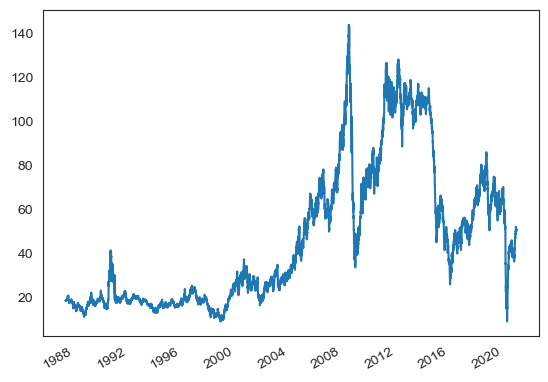

In [18]:
df['BRENT'].plot();

Text(0.5, 0, '')

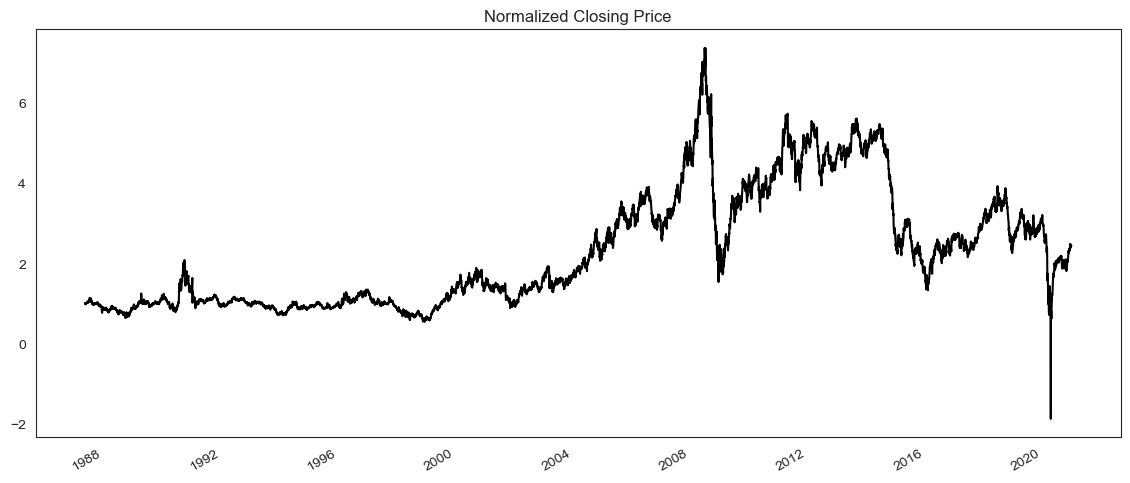

In [19]:
#Select the 'Close' column
close_col = df['WTI']

#Divide the 'Close' column by the first value in the column
normalized_close = close_col.div(close_col.iloc[0])

#Plot the normalized 'Close' column
ax = normalized_close.plot(figsize=(14, 6), title="Normalized Closing Price", legend=False, color='k')
ax.set_xlabel('')

## Plot Series

## Correlation

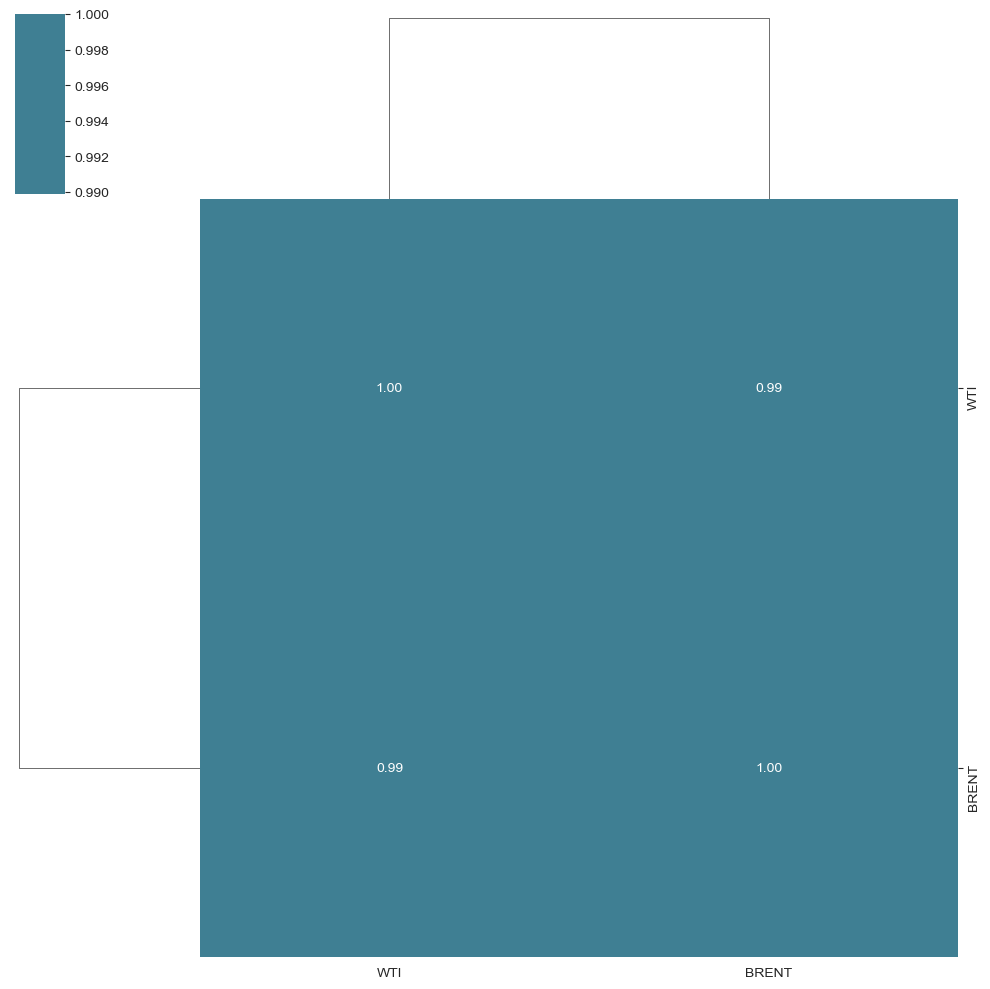

In [20]:
sns.clustermap(df.corr(),
               annot=True,
               fmt='.2f',
               cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0);

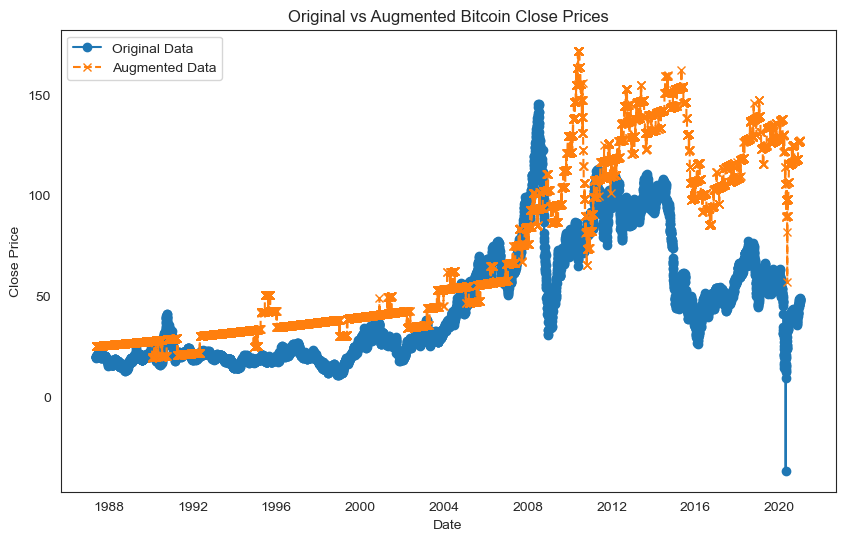

In [21]:
#Data augmentation without reverse

#Function creation for augmentation and plotting
def augment_data(original_data, augmentations):
    augmented_data = original_data.copy()
    augmented_data['WTI'] = augmentations.augment(original_data['WTI'].values)
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['WTI'], label='Original Data', marker='o')
    plt.plot(augmented_data.index, augmented_data['WTI'], label='Augmented Data', linestyle='--', marker='x')
    plt.title('Original vs Augmented Bitcoin Close Prices')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()
    return augmented_data

augmenter = (
    TimeWarp()
    + Crop(size=8402)
    + Quantize(n_levels=[10, 20, 30])
    + Drift(max_drift=(0.1, 0.5))
)

augmented_data = augment_data(df, augmenter)

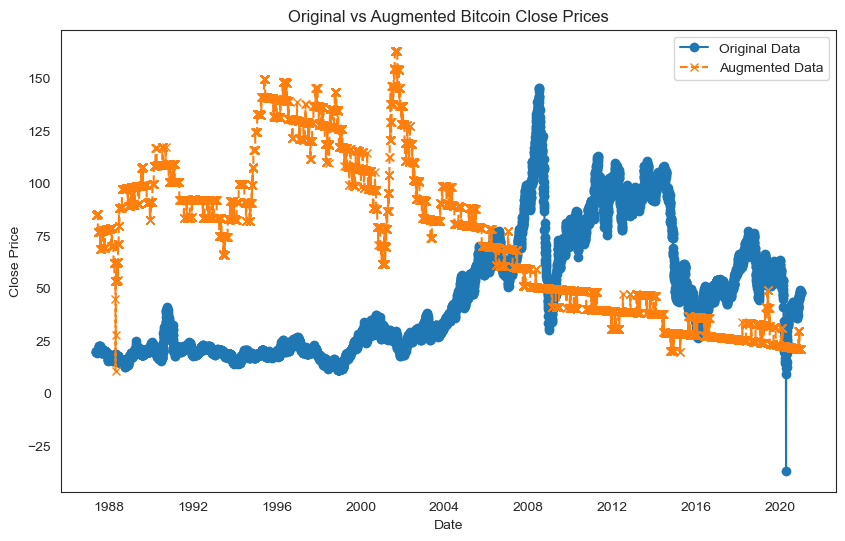

In [22]:
augmenter = (
    TimeWarp()
    + Crop(size=8402)
    + Quantize(n_levels=[10, 20, 30])
    + Drift(max_drift=(0.1, 0.5))
    + Reverse()
)

augmented_data = augment_data(df, augmenter)

## Data Scaling and autoencoders application


Epoch 1/20

211/211 [==============================] - 2s 4ms/step - loss: 0.0455 - val_loss: 0.0545
Epoch 2/20
211/211 [==============================] - 1s 3ms/step - loss: 0.0234 - val_loss: 0.0417
Epoch 3/20
211/211 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0135
Epoch 4/20
211/211 [==============================] - 1s 3ms/step - loss: 0.0132 - val_loss: 0.0061
Epoch 5/20
211/211 [==============================] - 1s 2ms/step - loss: 0.0097 - val_loss: 0.0035
Epoch 6/20
211/211 [==============================] - 1s 2ms/step - loss: 0.0079 - val_loss: 0.0021
Epoch 7/20
211/211 [==============================] - 1s 3ms/step - loss: 0.0065 - val_loss: 0.0020
Epoch 8/20
211/211 [==============================] - 1s 3ms/step - loss: 0.0059 - val_loss: 0.0016
Epoch 9/20
211/211 [==============================] - 1s 3ms/step - loss: 0.0056 - val_loss: 0.0013
Epoch 10/20
211/211 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.00

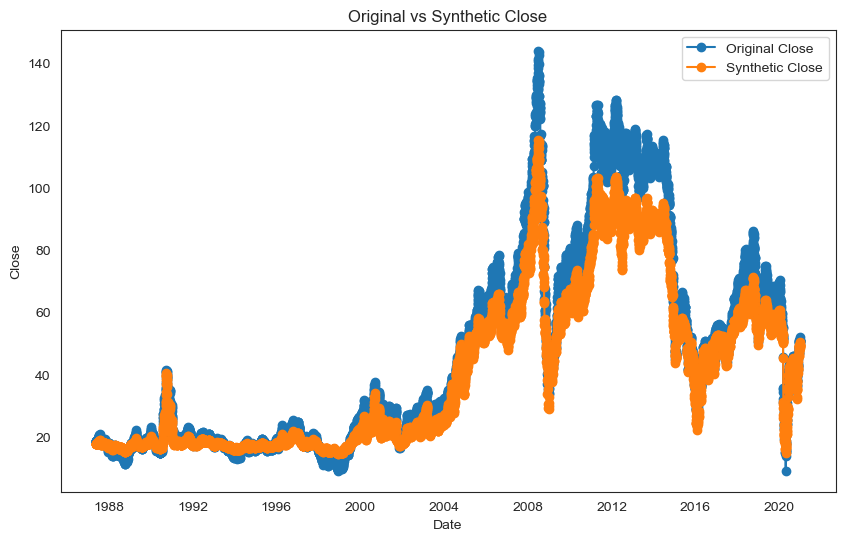

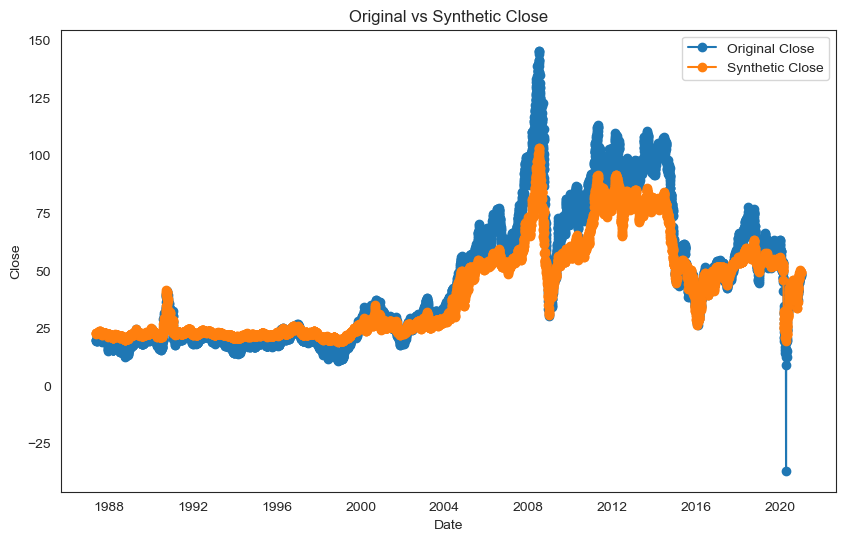

In [23]:
#Autoencoders in scaled data

columns_for_autoencoder = ['WTI', 'BRENT']
scaler = MinMaxScaler()
original_data_scaled = scaler.fit_transform(df[columns_for_autoencoder])

input_dim = len(columns_for_autoencoder)
encoding_dim = 80
timesteps = original_data_scaled.shape[0]

original_data_scaled = np.reshape(original_data_scaled, (timesteps, input_dim, 1))

autoencoder = Sequential()

#Encoder
autoencoder.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(input_dim, 1)))
autoencoder.add(BatchNormalization())
autoencoder.add(Dropout(0.6))

autoencoder.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(BatchNormalization())
autoencoder.add(Dropout(0.6))

autoencoder.add(Flatten())
autoencoder.add(Dense(encoding_dim, activation='relu'))

#Decoder
autoencoder.add(Dense(32 * input_dim, activation='relu'))
autoencoder.add(Reshape((input_dim, 32)))

autoencoder.add(Conv1DTranspose(filters=64, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(BatchNormalization())
autoencoder.add(Dropout(0.6))

autoencoder.add(Conv1DTranspose(filters=1, kernel_size=3, activation='sigmoid', padding='same'))

original_data_scaled = np.reshape(original_data_scaled, (timesteps, input_dim))

autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
autoencoder.fit(original_data_scaled, original_data_scaled, epochs=20, batch_size=32, shuffle=True, validation_split=0.2)

synthetic_data_scaled = autoencoder.predict(original_data_scaled)
synthetic_data = pd.DataFrame(data=scaler.inverse_transform(synthetic_data_scaled.reshape(timesteps, input_dim)), index=df.index, columns=columns_for_autoencoder)

synthetic_data = np.maximum(synthetic_data, 0)

table = pd.concat([df[columns_for_autoencoder], synthetic_data.rename(columns=lambda x: 'Synthetic ' + x)], axis=1)

#plotting
plt.figure(figsize=(10, 6))
plt.plot(table['BRENT'], label='Original Close', marker='o')
plt.plot(table['Synthetic BRENT'], label='Synthetic Close', marker='o')
plt.title('Original vs Synthetic Close')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(table['WTI'], label='Original Close', marker='o')
plt.plot(table['Synthetic WTI'], label='Synthetic Close', marker='o')
plt.title('Original vs Synthetic Close')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

# Time Gan

## Find Best Parameters

In [24]:
#Set the number of variables (sequences)
n_seq = 2

#Data scaling and rolling window creation to capture more temporal dependencies
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)


In [25]:
#Bayesian optimization

!pip install optuna-integration
!pip install optuna
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.callbacks import EarlyStopping

def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 16, 128)
    num_layers = trial.suggest_int('num_layers', 2, 4)
    seq_len = trial.suggest_int('seq_len', 15, 30)
    batch_size = trial.suggest_int('batch_size', 32, 256)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    train_steps = trial.suggest_int('train_steps', 500, 5000)

    def make_rnn(n_layers, hidden_units, output_units, name):
        return Sequential([GRU(units=hidden_units,
                               return_sequences=True,
                               name=f'GRU_{i + 1}') for i in range(n_layers)] +
                          [Dense(units=output_units,
                                 activation='sigmoid',
                                 name='OUT')], name=name)

    embedder = make_rnn(n_layers=num_layers, hidden_units=hidden_dim, output_units=hidden_dim, name='Embedder')
    recovery = make_rnn(n_layers=num_layers, hidden_units=hidden_dim, output_units=n_seq, name='Recovery')
    generator = make_rnn(n_layers=num_layers, hidden_units=hidden_dim, output_units=hidden_dim, name='Generator')
    discriminator = make_rnn(n_layers=num_layers, hidden_units=hidden_dim, output_units=1, name='Discriminator')
    supervisor = make_rnn(n_layers=num_layers-1, hidden_units=hidden_dim, output_units=hidden_dim, name='Supervisor')
    
    X = Input(shape=[seq_len, n_seq])
    H = embedder(X)
    X_tilde = recovery(H)
    
    autoencoder = Model(inputs=X, outputs=X_tilde, name='Autoencoder')
    autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    pruning_callback = TFKerasPruningCallback(trial, 'val_loss')
    
    
    data = []
    for i in range(len(df) - seq_len):
        data.append(scaled_data[i:i + seq_len])

    history = autoencoder.fit(np.asarray(data), np.asarray(data), epochs=75, batch_size=batch_size,
                           validation_split=0.2, callbacks=[early_stopping, pruning_callback], verbose=0)
    
    val_loss = min(history.history['val_loss'])
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters: ", study.best_params)

best_params = study.best_params
hidden_dim = best_params['hidden_dim']
num_layers = best_params['num_layers']
seq_len = best_params['seq_len']
batch_size = best_params['batch_size']
learning_rate = best_params['learning_rate']
train_steps = best_params['train_steps']

[I 2024-07-11 16:19:46,369] A new study created in memory with name: no-name-8bff69e8-9a54-44c4-a383-e250a479a76c


[I 2024-07-11 16:20:53,391] Trial 0 finished with value: 0.00035620524431578815 and parameters: {'hidden_dim': 39, 'num_layers': 3, 'seq_len': 23, 'batch_size': 247, 'learning_rate': 0.001333010889212819, 'train_steps': 2884}. Best is trial 0 with value: 0.00035620524431578815.
[I 2024-07-11 16:25:31,896] Trial 1 finished with value: 0.00031178502831608057 and parameters: {'hidden_dim': 118, 'num_layers': 2, 'seq_len': 28, 'batch_size': 163, 'learning_rate': 8.03680244377481e-05, 'train_steps': 3492}. Best is trial 1 with value: 0.00031178502831608057.
[I 2024-07-11 16:26:24,859] Trial 2 finished with value: 0.000359210156602785 and parameters: {'hidden_dim': 49, 'num_layers': 3, 'seq_len': 20, 'batch_size': 118, 'learning_rate': 0.0007593924482489019, 'train_steps': 1337}. Best is trial 1 with value: 0.00031178502831608057.
[I 2024-07-11 16:28:51,370] Trial 3 finished with value: 0.00023671513190492988 and parameters: {'hidden_dim': 112, 'num_layers': 3, 'seq_len': 22, 'batch_size': 2

Best hyperparameters:  {'hidden_dim': 106, 'num_layers': 2, 'seq_len': 17, 'batch_size': 33, 'learning_rate': 0.0009101901452998624, 'train_steps': 4364}


In [27]:
# Print the parameters
print(f"Hidden Dimension: {hidden_dim}")
print(f"Number of Layers: {num_layers}")
print(f"Sequence Length: {seq_len}")
print(f"Batch Size: {batch_size}")
print(f"Learning Rate: {learning_rate}")
print(f"Training Steps: {train_steps}")

Hidden Dimension: 106
Number of Layers: 2
Sequence Length: 17
Batch Size: 33
Learning Rate: 0.0009101901452998624
Training Steps: 4364


In [28]:
# hidden_dim = 96
# num_layers = 2
# seq_len = 94
# batch_size = 84
# learning_rate = 1.12e-05
# train_steps = 

## Create rolling window sequences

In [149]:
data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)

In [150]:
np.asarray(data).shape

(8385, 17, 2)

## Create tf.data.Dataset

In [151]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())
real_series

<_BatchDataset element_spec=TensorSpec(shape=(None, 17, 2), dtype=tf.float32, name=None)>

## Set up random series generator

In [152]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

We use the Python generator to feed a `tf.data.Dataset` that continues to call the random number generator as long as necessary and produces the desired batch size.

In [153]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

# TimeGAN Components

The design of the TimeGAN components follows the author's sample code.

##  Network Parameters

In [154]:
#hidden_dim = 24
#num_layers = 3

## Set up logger

In [155]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

## Input place holders

In [156]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

## RNN block generator

We keep it very simple and use a very similar architecture for all four components. For a real-world application, they should be tailored to the data.

In [157]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

## Embedder & Recovery

In [158]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

## Generator & Discriminator

In [159]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

In [160]:
#Encoder Function
def build_encoder(input_shape, latent_dim):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(latent_dim, activation=None))
    return model

#Decoder Function
def build_decoder(output_shape, latent_dim):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(latent_dim,)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(output_shape[0] * output_shape[1], activation='relu'))
    model.add(layers.Reshape((output_shape[0], output_shape[1])))
    model.add(layers.Conv1DTranspose(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(layers.Conv1DTranspose(1, kernel_size=5, strides=1, padding='same', activation='sigmoid'))
    return model

#Instantiate the encoder and decoder
input_shape = (seq_len, n_seq)
latent_dim = 20
encoder = build_encoder(input_shape, latent_dim)
decoder = build_decoder(input_shape, latent_dim)

# TimeGAN Training

## Settings

In [161]:
#train_steps = 5000
gamma = 1

## Generic Loss Functions

In [162]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

# Phase 1: Autoencoder Training

## Architecture

In [163]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [164]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 17, 2)]           0         
                                                                 
 Embedder (Sequential)       (None, 17, 106)           182426    
                                                                 
 Recovery (Sequential)       (None, 17, 2)             204370    
                                                                 
Total params: 386796 (1.48 MB)
Trainable params: 386796 (1.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [165]:
plot_model(autoencoder,
           to_file=(results_path / 'autoencoder.png').as_posix(),
           show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Autoencoder Optimizer

In [166]:
autoencoder_optimizer = Adam()

## Autoencoder Training Step

In [167]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Autoencoder Training Loop

In [48]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|██████████| 4364/4364 [01:39<00:00, 43.94it/s]


## Persist model

In [49]:
autoencoder.save(log_dir / 'autoencoder')

INFO:tensorflow:Assets written to: time_gan\experiment_01\autoencoder\assets


INFO:tensorflow:Assets written to: time_gan\experiment_01\autoencoder\assets


# Phase 2: Supervised training

## Define Optimizer

In [168]:
supervisor_optimizer = Adam()

## Train Step

In [169]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

## Training Loop

In [52]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 4364/4364 [01:01<00:00, 71.02it/s]


## Persist Model

In [53]:
supervisor.save(log_dir / 'supervisor')

INFO:tensorflow:Assets written to: time_gan\experiment_01\supervisor\assets


INFO:tensorflow:Assets written to: time_gan\experiment_01\supervisor\assets


# Joint Training

## Generator

### Adversarial Architecture - Supervised

In [170]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [171]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 17, 2)]           0         
                                                                 
 Generator (Sequential)      (None, 17, 106)           182426    
                                                                 
 Supervisor (Sequential)     (None, 17, 106)           147446    
                                                                 
 Discriminator (Sequential)  (None, 17, 1)             204263    
                                                                 
Total params: 534135 (2.04 MB)
Trainable params: 534135 (2.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [172]:
plot_model(adversarial_supervised, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Adversarial Architecture in Latent Space

In [173]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [174]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 17, 2)]           0         
                                                                 
 Generator (Sequential)      (None, 17, 106)           182426    
                                                                 
 Discriminator (Sequential)  (None, 17, 1)             204263    
                                                                 
Total params: 386689 (1.48 MB)
Trainable params: 386689 (1.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [175]:
plot_model(adversarial_emb, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Mean & Variance Loss

In [176]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [177]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 17, 2)]           0         
                                                                 
 Generator (Sequential)      (None, 17, 106)           182426    
                                                                 
 Supervisor (Sequential)     (None, 17, 106)           147446    
                                                                 
 Recovery (Sequential)       (None, 17, 2)             204370    
                                                                 
Total params: 534242 (2.04 MB)
Trainable params: 534242 (2.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [178]:
plot_model(synthetic_data, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [179]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

## Discriminator

### Architecture: Real Data

In [180]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [181]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 17, 2)]           0         
                                                                 
 Embedder (Sequential)       (None, 17, 106)           182426    
                                                                 
 Discriminator (Sequential)  (None, 17, 1)             204263    
                                                                 
Total params: 386689 (1.48 MB)
Trainable params: 386689 (1.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [182]:
plot_model(discriminator_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Optimizers

In [183]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

## Generator Train Step

In [184]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

## Embedding Train Step

In [185]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Discriminator Train Step

In [186]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [187]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

In [188]:
@tf.function
def train_encoder_decoder(real_data):
    with tf.GradientTape() as tape:
        encoded_data = encoder(real_data, training=True)
        reconstructed_data = decoder(encoded_data, training=True)
        reconstruction_loss = reconstruction_loss_fn(real_data, reconstructed_data)
    gradients = tape.gradient(reconstruction_loss, encoder.trainable_variables + decoder.trainable_variables)
    encoder_decoder_optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + decoder.trainable_variables))
    return reconstruction_loss

## Training Loop

In [189]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = step_ed_loss = 0

#Loss function and Optimizer for encoder-decoder training
reconstruction_loss_fn = tf.keras.losses.MeanSquaredError()
encoder_decoder_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

for step in range(train_steps):
    #Train generator twice as often as discriminator
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        #Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        #Train embedder
        step_e_loss_t0 = train_embedder(X_)
        #Train encoder-decoder
        step_ed_loss = train_encoder_decoder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f} | '
              f'ed_loss: {step_ed_loss:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)
        tf.summary.scalar('ED Loss', step_ed_loss, step=step)

     0 | d_loss: 2.0593 | g_loss_u: 0.7141 | g_loss_s: 0.0009 | g_loss_v: 0.2594 | e_loss_t0: 0.2109 | ed_loss: 0.0746
 1,000 | d_loss: 1.7387 | g_loss_u: 1.3975 | g_loss_s: 0.0003 | g_loss_v: 0.1107 | e_loss_t0: 0.0073 | ed_loss: 0.0100
 2,000 | d_loss: 1.7299 | g_loss_u: 1.3400 | g_loss_s: 0.0001 | g_loss_v: 0.0416 | e_loss_t0: 0.0026 | ed_loss: 0.0099
 3,000 | d_loss: 1.7830 | g_loss_u: 1.1698 | g_loss_s: 0.0001 | g_loss_v: 0.0297 | e_loss_t0: 0.0032 | ed_loss: 0.0107
 4,000 | d_loss: 1.7944 | g_loss_u: 1.3707 | g_loss_s: 0.0000 | g_loss_v: 0.0137 | e_loss_t0: 0.0056 | ed_loss: 0.0095


In [190]:
#Anomalies detection
data_sequences = []
for i in range(len(scaled_data) - seq_len):
    data_sequences.append(scaled_data[i:i + seq_len])
data_sequences = np.array(data_sequences)

data_sequences_reshaped = data_sequences.reshape(-1, seq_len, n_seq)

def detect_anomalies(data, encoder, decoder, threshold):
    encoded_data = encoder(data, training=False)
    reconstructed_data = decoder(encoded_data, training=False)
    reconstruction_error = tf.reduce_mean(tf.square(data - reconstructed_data), axis=[1, 2])
    anomalies = reconstruction_error > threshold
    return anomalies, reconstruction_error

threshold = 0.015
original_indices = np.arange(len(data_sequences_reshaped))
anomalies, reconstruction_errors = detect_anomalies(data_sequences_reshaped, encoder, decoder, threshold)

## Persist Synthetic Data Generator

In [191]:
synthetic_data.save(log_dir / 'synthetic_data')

INFO:tensorflow:Assets written to: time_gan\experiment_01\synthetic_data\assets


INFO:tensorflow:Assets written to: time_gan\experiment_01\synthetic_data\assets


# Generate Synthetic Data

In [192]:
#Store synthetic data
generated_data_scaled = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data_scaled.append(d)

In [193]:
generated_data_scaled = np.array(np.vstack(generated_data_scaled))
generated_data_scaled.shape

(8382, 17, 2)

In [194]:
original_indices = np.arange(len(data_sequences_reshaped))
def filter_data_with_indices(generated_data_batches, encoder, decoder, threshold):
    improved_generated_data = []
    improved_indices = []
    anomalous_data = []
    anomalous_indices = []
    
    for batch_index, batch in enumerate(generated_data_batches):
        for sample_index, sample in enumerate(batch):
            sample = tf.reshape(sample, [1, sample.shape[0], sample.shape[1]])
            
            # Encode and decode
            encoded_sample = encoder(sample, training=False)
            reconstructed_sample = decoder(encoded_sample, training=False)
            
            # Reconstruction error calculation
            reconstruction_error = tf.reduce_mean(tf.square(sample - reconstructed_sample))
            
            # Filter out anomalies based on reconstruction error
            if reconstruction_error < threshold:
                improved_generated_data.append(sample)
                improved_indices.append(batch_index * len(batch) + sample_index)
            else:
                anomalous_data.append(sample)
                anomalous_indices.append(batch_index * len(batch) + sample_index)
    
    improved_generated_data = np.array(improved_generated_data)
    
    #Reshape back
    improved_generated_data = np.reshape(improved_generated_data, (-1, seq_len, n_seq))
    return improved_generated_data, improved_indices, anomalous_indices

improved_generated_data, improved_indices, anomalous_indices = filter_data_with_indices(generated_data_batches, encoder, decoder, threshold)
print(improved_generated_data.shape)

#Create the filtered DataFrame using the improved indices
filtered_df = df.iloc[improved_indices].reset_index(drop=True)
print(filtered_df)

# excluded_df = original_df.iloc[anomalous_indices].reset_index(drop=True)

(5717, 17, 2)
             0         1
0     0.312305  0.069336
1     0.310823  0.070078
2     0.309013  0.070671
3     0.309178  0.070449
4     0.308629  0.070449
...        ...       ...
5712  0.433211  0.257249
5713  0.448132  0.278309
5714  0.452905  0.283278
5715  0.450820  0.279867
5716  0.450985  0.286986

[5717 rows x 2 columns]
             0         1
0     0.311207  0.070671
1     0.310110  0.070819
2     0.311427  0.070819
3     0.312250  0.071561
4     0.312195  0.071783
...        ...       ...
2660  0.408251  0.215573
2661  0.422568  0.236040
2662  0.428767  0.245829
2663  0.438258  0.266222
2664  0.447200  0.281275

[2665 rows x 2 columns]


In [78]:
#Anomalies filtering
def filter_data(generated_data_batches, encoder, decoder, threshold):
    improved_generated_data = []
    anomalous_data = []
    for batch in generated_data_batches:
        for sample in batch:
            sample = tf.reshape(sample, [1, sample.shape[0], sample.shape[1]])
            
            #Encode and decode
            encoded_sample = encoder(sample, training=False)
            reconstructed_sample = decoder(encoded_sample, training=False)
            
            #Reconstruction error calculation
            reconstruction_error = tf.reduce_mean(tf.square(sample - reconstructed_sample))
            
            #Filter out anomalies based on reconstruction error
            if reconstruction_error < threshold:
                improved_generated_data.append(sample)
            else:
                anomalous_data.append(sample)
                
    improved_generated_data = np.array(improved_generated_data)
    
    #Reshape back to original sample shape
    improved_generated_data = np.reshape(improved_generated_data, (-1, seq_len, 2))
    
    return improved_generated_data

threshold = 0.015 
generated_data_batches = [generated_data_scaled]

improved_generated_data = filter_data(generated_data_batches, encoder, decoder, threshold)
print(improved_generated_data.shape)

(5721, 17, 2)


In [195]:
len(generated_data_scaled)

8382

In [196]:
np.save(log_dir / 'generated_data.npy', generated_data_scaled)

## Rescale

In [197]:
generated_data = (scaler.inverse_transform(generated_data_scaled
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
print(generated_data.shape)
generated_ano_data = (scaler.inverse_transform(improved_generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
print(generated_ano_data.shape)

differences = generated_data != generated_ano_data
indices = np.where(differences)
print(indices)

(8382, 17, 2)
(5717, 17, 2)
(array([0], dtype=int64),)


## Persist Data

In [82]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq),
                                             columns=['WTI','BRENT']))

## Plot sample Series

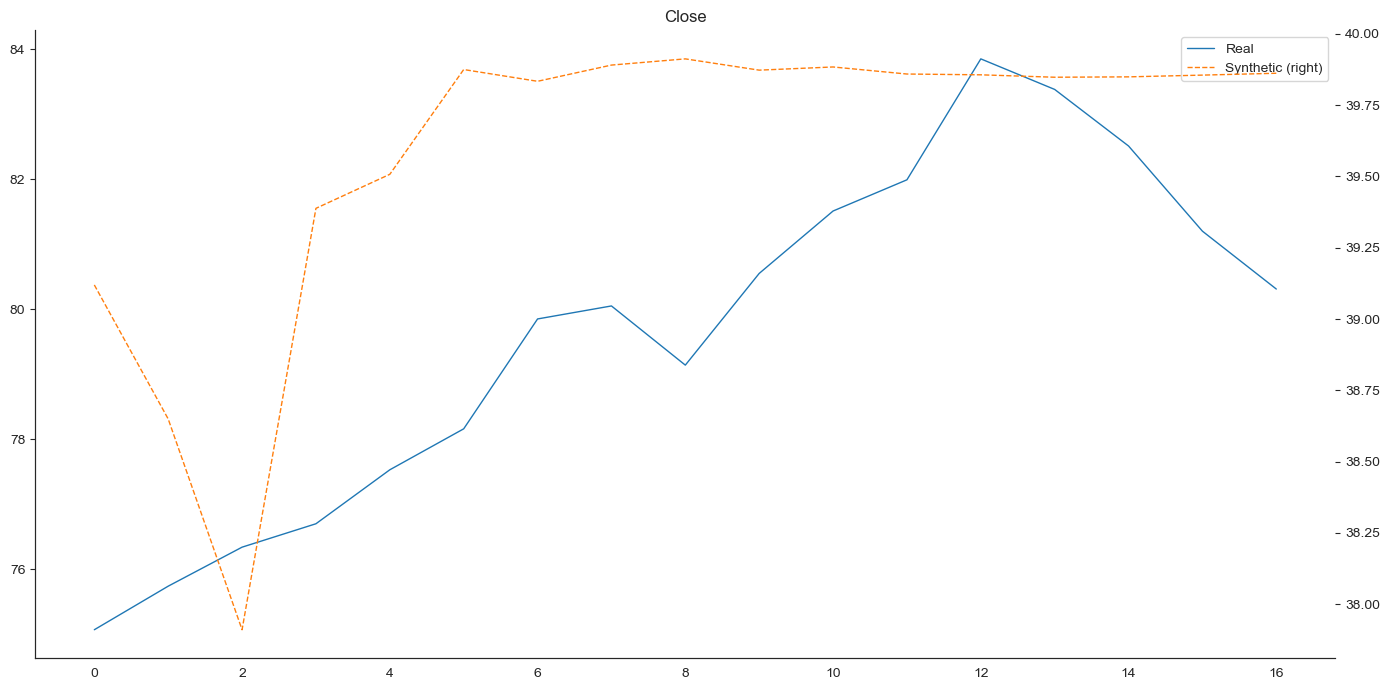

In [218]:
##Plotting synthetic vs real with anomalies
#Generate synthetic data for a random window
rand = np.random.randint(len(improved_generated_data))
synthetic = generated_data[rand]

#Select a random real data window
idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

#Create a DataFrame with both real and synthetic data
data_to_plot = pd.DataFrame({
    'Real': real['WTI'].values,
    'Synthetic': synthetic[:, 0]
})

#Plotting
fig, ax = plt.subplots(figsize=(14, 7))
data_to_plot.plot(ax=ax, title='Close', secondary_y='Synthetic', style=['-', '--'], lw=1)
sns.despine()
fig.tight_layout()
plt.show()

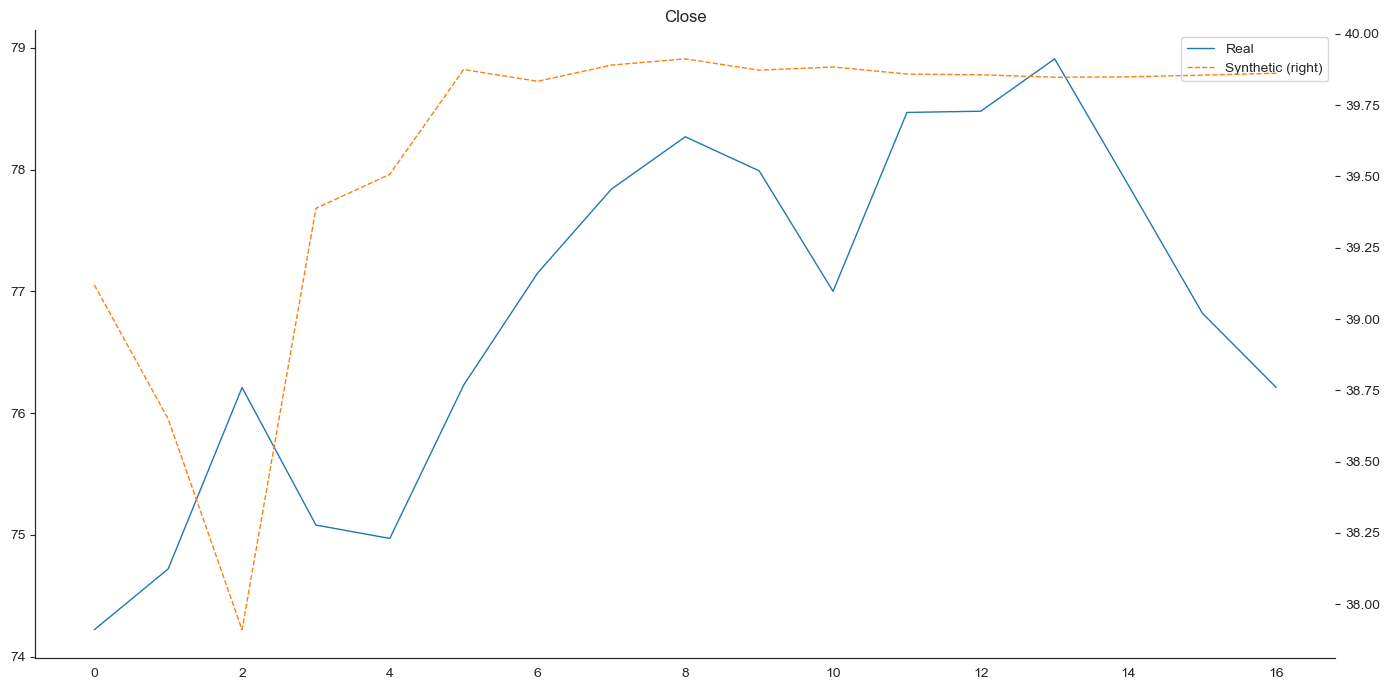

In [219]:
##Plotting synthetic vs real with anomalies
synthetic = generated_data[rand]

# idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

data_to_plot = pd.DataFrame({
    'Real': real['BRENT'].values,
    'Synthetic': synthetic[:, 0] 
})

fig, ax = plt.subplots(figsize=(14, 7))
data_to_plot.plot(ax=ax, title='Close', secondary_y='Synthetic', style=['-', '--'], lw=1)
sns.despine()
fig.tight_layout()
plt.show()

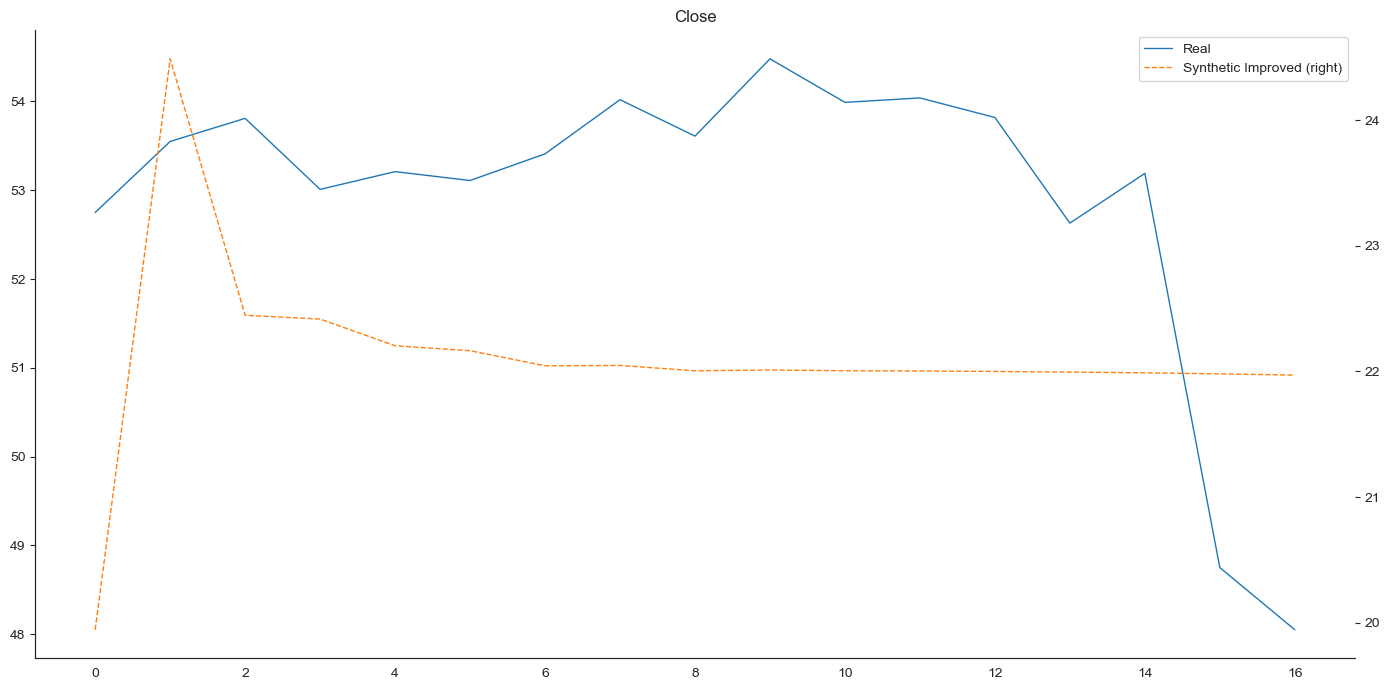

In [220]:
##Plotting synthetic vs real without anomalies
synthetic_ano_data = generated_ano_data[rand]

# idx = np.random.randint(len(filtered_df) - seq_len)
real = filtered_df.iloc[idx: idx + seq_len]

data_to_plot = pd.DataFrame({
    'Real': real['WTI'].values,
    'Synthetic Improved': synthetic_ano_data[:, 0]
})

fig, ax = plt.subplots(figsize=(14, 7))
data_to_plot.plot(ax=ax, title='Close', secondary_y='Synthetic Improved', style=['-', '--'], lw=1)
sns.despine()
fig.tight_layout()
plt.show()

## Evaluation

In [88]:
experiment = 1

In [89]:
df.to_hdf(hdf_store, 'data/real')

In [221]:
def get_real_data():
    df = pd.read_hdf(hdf_store, 'data/real').sort_index()

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    data = []
    for i in range(len(df) - seq_len):
        data.append(scaled_data[i:i + seq_len])
    return data


real_data = get_real_data()

In [222]:
n = len(real_data)
n

8385

In [223]:
np.asarray(real_data).shape

(8385, 17, 2)

In [224]:
synthetic_data = improved_generated_data
synthetic_data.shape

(5717, 17, 2)

In [225]:
real_data = real_data[:synthetic_data.shape[0]]
len(real_data)

5717

In [226]:
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

In [227]:
#Data preprocessing
#Get data ready for evaluation
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

In [228]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

In [229]:
real_sample_2d.shape, synthetic_sample_2d.shape

((500, 17), (500, 17))

In [230]:
#PCA
pca = PCA(n_components=2)
pca.fit(real_sample_2d)

#Transform the data and create DataFrames with an additional 'Data' column
pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
            .assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                 .assign(Data='Synthetic'))

#Concatenate the DataFrames and rename the columns
pca_result = pd.concat([pca_real, pca_synthetic]).rename(
    columns={0: '1st Component', 1: '2nd Component'})

print(pca_result)


     1st Component  2nd Component       Data
0        -0.267710       0.513027       Real
1        -0.390198      -0.479514       Real
2        -0.265403       0.501903       Real
3        -0.311203      -0.463114       Real
4        -0.309661       0.524549       Real
..             ...            ...        ...
495       0.299625      -0.385843  Synthetic
496      -0.271050       0.516108  Synthetic
497      -0.402162      -0.478865  Synthetic
498       1.612491      -0.062859  Synthetic
499       1.624822      -0.094674  Synthetic

[1000 rows x 3 columns]


In [231]:
#TSNE
tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=200)
tsne_result = tsne.fit_transform(tsne_data)

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.217871
[t-SNE] KL divergence after 250 iterations with early exaggeration: 40.617035
[t-SNE] KL divergence after 1000 iterations: 0.103287


In [232]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*3:, 'Data'] = 'Synthetic'

In [233]:
tsne_result

,X,Y,Data
0,-3.267483,10.242616,Real
1,-8.017493,-8.609714,Real
2,-3.315542,10.168160,Real
3,-7.348043,-8.060805,Real
4,-2.841774,10.904037,Real
...,...,...,...
995,-4.267577,-4.601428,Synthetic
996,-2.631395,10.375371,Synthetic
997,-8.163305,-8.707035,Synthetic
998,1.865774,-0.726390,Synthetic


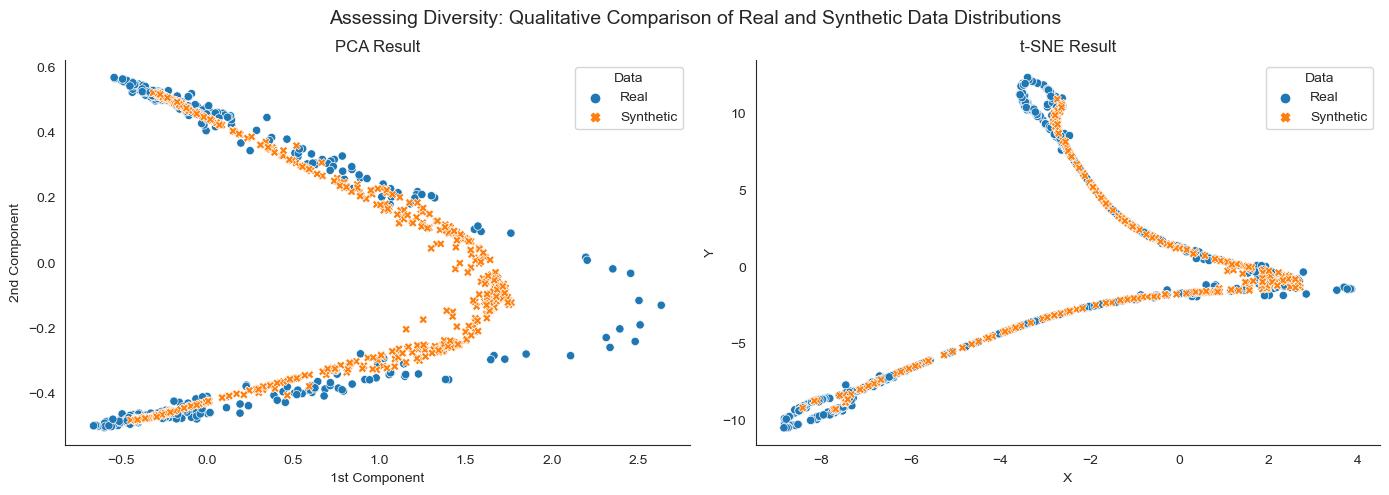

In [234]:
#Plotting PCA and tsne
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

#PCA Result
sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')

#t-SNE Result
sns.scatterplot(x='X', y='Y', data=tsne_result,
                hue='Data', style='Data', ax=axes[1])
sns.despine()
axes[1].set_title('t-SNE Result')

fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88)

plt.show()

In [235]:
real_data = get_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]

In [114]:
synthetic_data.shape

(5721, 17, 2)

In [115]:
n_series = real_data.shape[0]

In [116]:
idx = np.arange(n_series)

In [117]:
n_train = int(.8*n_series)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [118]:
train_data = np.vstack((real_data[train_idx], 
                        synthetic_data[train_idx]))
test_data = np.vstack((real_data[test_idx], 
                       synthetic_data[test_idx]))

In [119]:
n_train, n_test = len(train_idx), len(test_idx)
train_labels = np.concatenate((np.ones(n_train),
                               np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test),
                              np.zeros(n_test)))

In [120]:
ts_classifier = Sequential([GRU(2, input_shape=(seq_len, 2), name='GRU'),
                            Dense(1, activation='sigmoid', name='OUT')],
                           name='Time_Series_Classifier')

In [121]:
ts_classifier.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=[AUC(name='AUC'), 'accuracy'])

In [122]:
ts_classifier.summary()

Model: "Time_Series_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU (GRU)                   (None, 2)                 36        
                                                                 
 OUT (Dense)                 (None, 1)                 3         
                                                                 
Total params: 39 (156.00 Byte)
Trainable params: 39 (156.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [123]:
test_data

array([[[0.54945417, 0.38717093],
        [0.56053541, 0.39006303],
        [0.55746338, 0.39154616],
        ...,
        [0.56141313, 0.38961809],
        [0.55252619, 0.37130145],
        [0.54605299, 0.37248795]],

       [[0.56053541, 0.39006303],
        [0.55746338, 0.39154616],
        [0.54797301, 0.38101594],
        ...,
        [0.55252619, 0.37130145],
        [0.54605299, 0.37248795],
        [0.54193867, 0.35669262]],

       [[0.55746338, 0.39154616],
        [0.54797301, 0.38101594],
        [0.5715618 , 0.40741565],
        ...,
        [0.54605299, 0.37248795],
        [0.54193867, 0.35669262],
        [0.54193867, 0.35736003]],

       ...,

       [[0.34300449, 0.11062789],
        [0.38158301, 0.18187575],
        [0.36817646, 0.15648   ],
        ...,
        [0.37998378, 0.16626191],
        [0.38005218, 0.16639641],
        [0.38009354, 0.16649292]],

       [[0.32304472, 0.08383238],
        [0.3500388 , 0.13273405],
        [0.33740991, 0.1114011 ],
        .

In [124]:
#Train model with the modified input data
result = ts_classifier.fit(x=train_data,
                            y=train_labels,
                            validation_data=(test_data, test_labels),
                            epochs=250,
                            batch_size=128,
                            verbose=0)

In [125]:
ts_classifier.evaluate(x=test_data, y=test_labels)

72/72 [==============================] - 0s 1ms/step - loss: 1.2957 - AUC: 0.6563 - accuracy: 0.5913


[1.2956972122192383, 0.6563390493392944, 0.591266393661499]

In [126]:
history = pd.DataFrame(result.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          250 non-null    float64
 1   AUC           250 non-null    float64
 2   accuracy      250 non-null    float64
 3   val_loss      250 non-null    float64
 4   val_AUC       250 non-null    float64
 5   val_accuracy  250 non-null    float64
dtypes: float64(6)
memory usage: 11.8 KB


In [127]:
from matplotlib.ticker import FuncFormatter

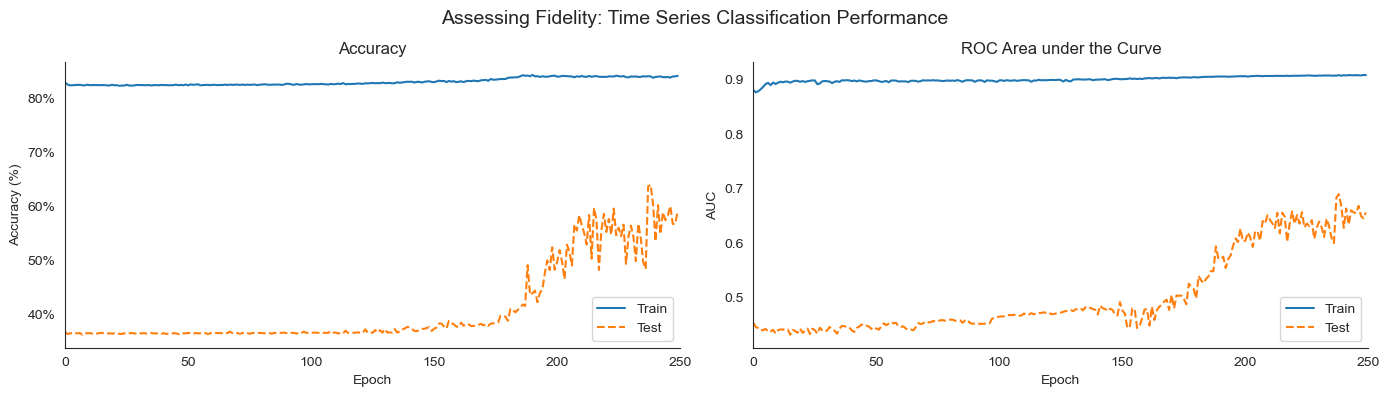

In [128]:
sns.set_style('white')
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1], 
                                                                                     title='ROC Area under the Curve',
                                                                                    style=['-', '--'],
                                                                                    xlim=(0, 250))
history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0], 
                                                                                                         title='Accuracy',
                                                                                                        style=['-', '--'],
                                                                                                        xlim=(0, 250))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('AUC')
sns.despine()
fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

In [129]:
real_data = get_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]

In [130]:
real_data.shape, synthetic_data.shape

((5721, 17, 2), (5721, 17, 2))

In [131]:
real_train_data = real_data[train_idx, :23, :]
real_train_label = real_data[train_idx, -1, :]

real_test_data = real_data[test_idx, :23, :]
real_test_label = real_data[test_idx, -1, :]

In [132]:
real_train_data.shape, real_train_label.shape, real_test_data.shape, real_test_label.shape

((4576, 17, 2), (4576, 2), (1145, 17, 2), (1145, 2))

In [133]:
synthetic_train = synthetic_data[:, :23, :]
synthetic_label = synthetic_data[:, -1, :]

In [134]:
synthetic_train.shape, synthetic_label.shape

((5721, 17, 2), (5721, 2))

In [138]:
def get_model():
    model = Sequential()
    model.add(LSTM(50, input_shape=(seq_len, 2), return_sequences=False))
    model.add(Dense(2))
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

In [139]:
ts_regression = get_model()
real_result = ts_regression.fit(x=real_train_data,
                                y=real_train_label,
                                validation_data=(
                                    real_test_data, 
                                    real_test_label),
                                epochs=100,
                                batch_size=128,
                                verbose=0)

In [140]:
ts_regression = get_model()
synthetic_result = ts_regression.fit(x=synthetic_train,
                                     y=synthetic_label,
                                     validation_data=(
                                         real_test_data, 
                                         real_test_label),
                                     epochs=100,
                                     batch_size=128,
                                     verbose=0)

In [141]:
synthetic_result = pd.DataFrame(synthetic_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})
real_result = pd.DataFrame(real_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})

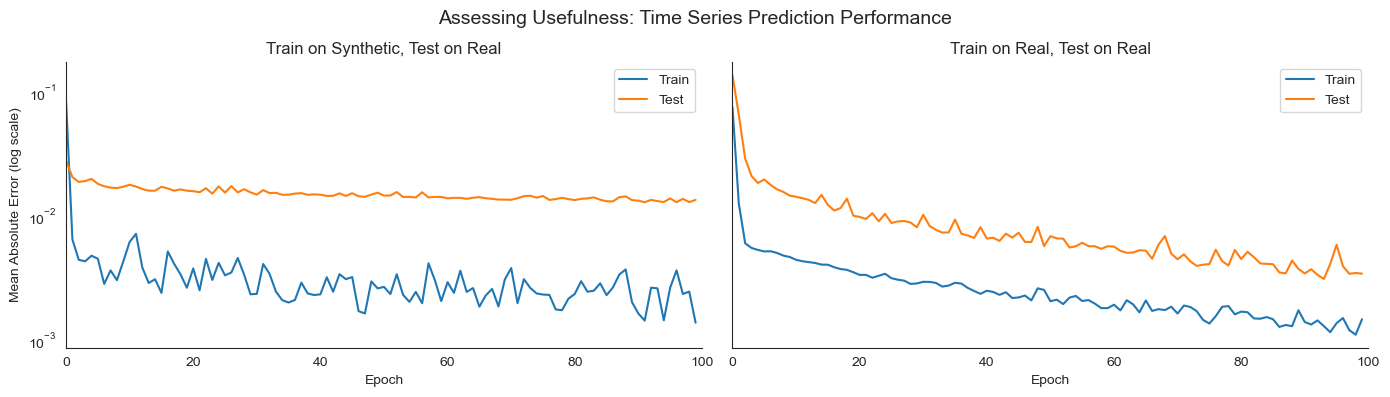

In [142]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)
synthetic_result.plot(ax=axes[0], title='Train on Synthetic, Test on Real', logy=True, xlim=(0, 100))
real_result.plot(ax=axes[1], title='Train on Real, Test on Real', logy=True, xlim=(0, 100))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Mean Absolute Error (log scale)')

sns.despine()
fig.suptitle('Assessing Usefulness: Time Series Prediction Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);